<a href="https://colab.research.google.com/github/robertej19/6862_ML_Project/blob/main/Personal_nflib1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [274]:
#Copy code into CoLab space
!git clone https://github.com/6862-2021SP-team3/pytorch-normalizing-flows.git

fatal: destination path 'pytorch-normalizing-flows' already exists and is not an empty directory.


In [6]:
#Copy training data from online repository
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-11 16:47:13--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-11 16:47:13--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb6bd233d3cf6de148c9d28ccbd.dl.dropboxusercontent.com/cd/0/inline/BMbvmRqu73Ogkq4Sw9S_cKe_BCDWClluovvKtl_dSN3cyRb4-qpDRKDzsVVbk67canP4slljflWY66I7KFkaC3ZiehTtZaFO4iAm4-WlR97Wd-u2jcgoca_K6rB9m4QQx41Lg-Kqb6SEtpSY42rlMD1v/file# [following]
--2021-04-11 16:47:14--  https://ucb6bd233d3cf6de148c9d28ccbd.dl.dropboxusercontent.com/cd/0/inline/BMbvmRqu73Ogkq4Sw9S_cKe_BCDWClluovvKtl_dSN3cyRb4-qpDRKDzsVVbk67canP4slljflWY66I7KFkaC3ZiehTtZaFO4iAm

In [7]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [14]:
#Add local modules to path
import sys
sys.path.insert(0,'/content/pytorch-normalizing-flows')


In [54]:
#Standard import statements
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from datetime import datetime

#Pytorch imports
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

#NFlow library imports
from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [56]:
xz = dataXZ()
z = xz.z
x = xz.x

#Let's look at the data
sampleDict = xz.sample(30000) #Get a subset of the datapoints
x = sampleDict["xwithoutPid"][:, 0:2] #For now, only 
#print(x)
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)

x= x.detach().numpy()

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

In [8]:
sampleDict = xz.sample(100)
print(sampleDict["xz"][0])
print(sampleDict["xwithoutPid"][0])


[  4.9083767   14.268987   -65.629005     1.           0.6411379
  31.645304   -23.77509      2.           3.6934936   16.222567
 120.02271      3.           2.0198796   15.316601   130.08167
   3.           4.945632    14.221563   -65.32662      1.
   0.66746944  30.86915    -22.427876     2.           3.2947173
  16.279282   119.88604      3.           2.1465552   15.29344
 129.95393      3.        ]
tensor([  4.9084,  14.2690, -65.6290,   0.6411,  31.6453, -23.7751,   3.6935,
         16.2226, 120.0227,   2.0199,  15.3166, 130.0817])


In [407]:
# construct a model
# try with electron momentum magintude and polar angle only
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model
model = NormalizingFlowModel(prior, flows)

In [408]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [409]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))




Start Time = 22:36:13
On step 0 - loss 16889.37, Current Running Time = 0.04 seconds
On step 100 - loss 7720.04, Current Running Time = 2.06 seconds
On step 200 - loss 3553.77, Current Running Time = 4.05 seconds
On step 300 - loss 3512.22, Current Running Time = 6.03 seconds
On step 400 - loss 3473.89, Current Running Time = 8.01 seconds
On step 500 - loss 3432.47, Current Running Time = 9.98 seconds
On step 600 - loss 3422.97, Current Running Time = 11.96 seconds
On step 700 - loss 3362.75, Current Running Time = 13.93 seconds
On step 800 - loss 3331.87, Current Running Time = 15.89 seconds
On step 900 - loss 3307.42, Current Running Time = 17.86 seconds
On step 1000 - loss 3272.45, Current Running Time = 19.80 seconds
On step 1100 - loss 3216.25, Current Running Time = 21.77 seconds
On step 1200 - loss 3191.80, Current Running Time = 23.71 seconds
On step 1300 - loss 3161.87, Current Running Time = 25.67 seconds
On step 1400 - loss 3134.19, Current Running Time = 27.65 seconds
On st

Text(0, 0.5, 'Loss')

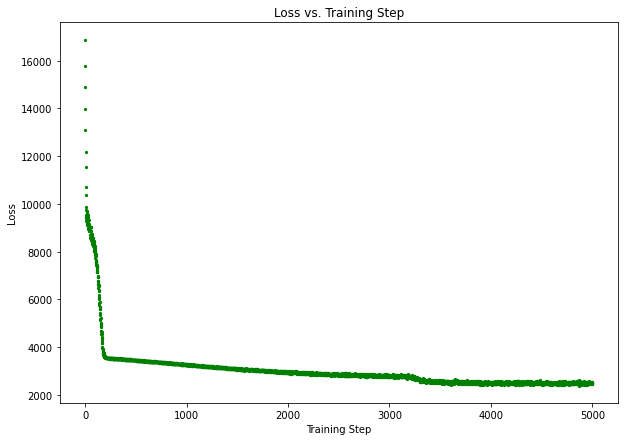

In [410]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.scatter(np.arange(len(losses)),losses, c='g', s=5)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

tensor([ 6.4755, 12.0919])
space
space


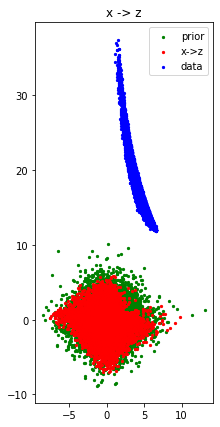

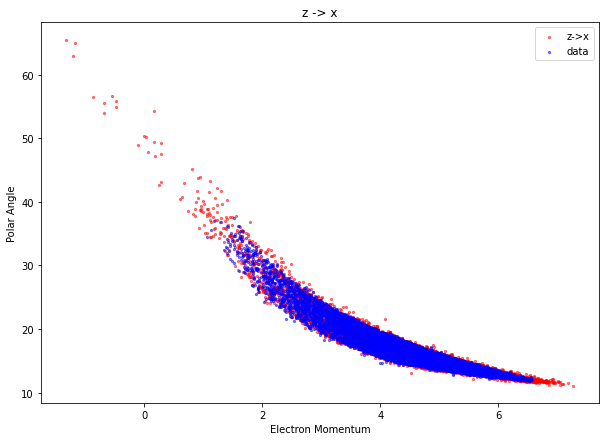

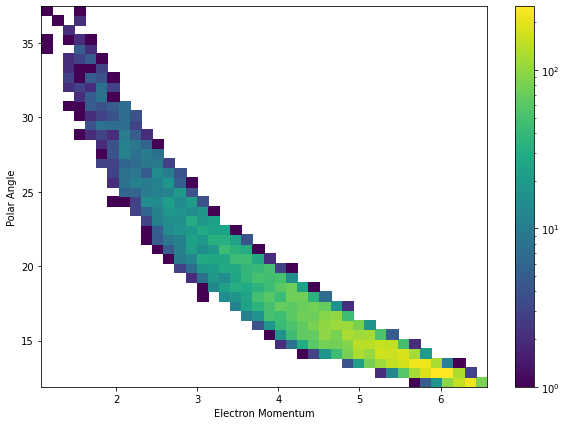

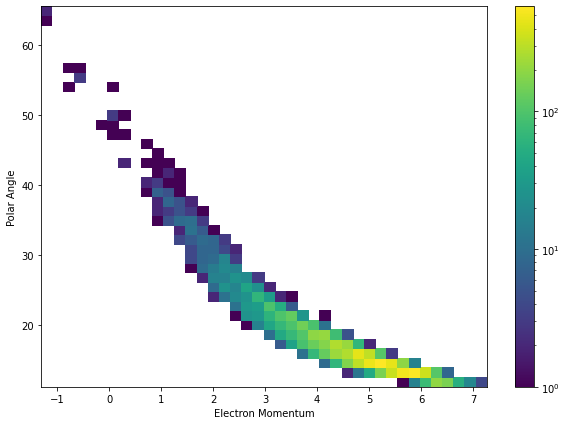

In [411]:
model.eval()

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(x[0])
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([10000, 2]).squeeze()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
print("space")
zs = model.sample(10000)
z = zs[-1]
z = z.detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['z->x','data'])
plt.title('z -> x')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()
print("space")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

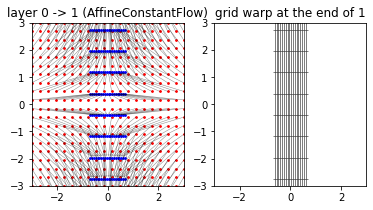

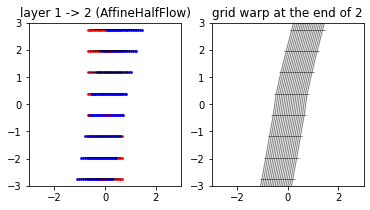

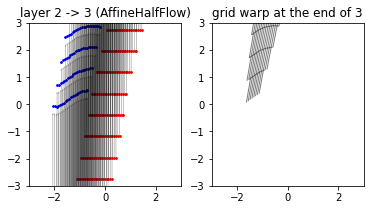

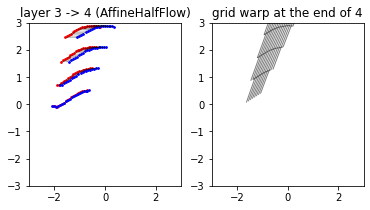

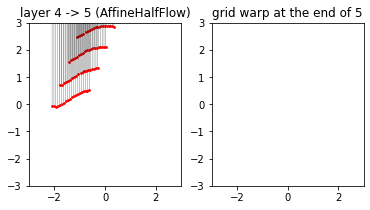

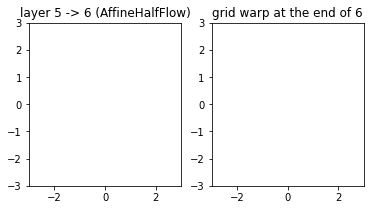

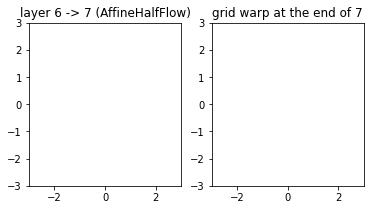

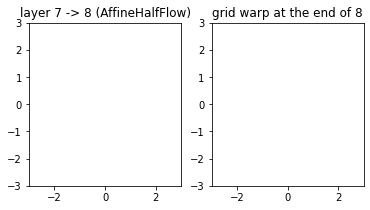

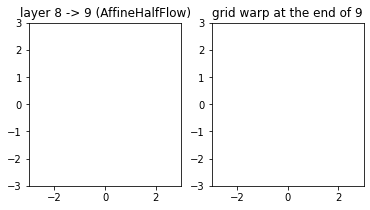

In [74]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.backward(xy)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)
    


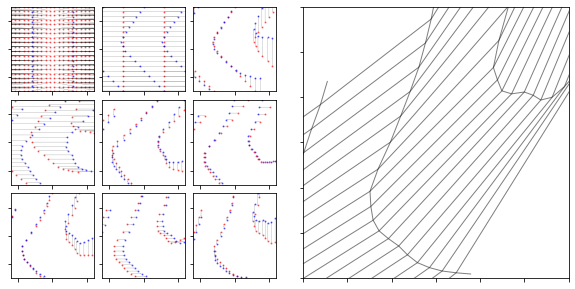

In [ ]:

# train and render
# code duplication because it's very late at night now and i'm tired

import matplotlib.gridspec as gridspec

ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

# xval = d.sample(128*5)
sampleDict = xz.sample(128*5)
xval = sampleDict["xwithoutPid"][:, 0:2]

model.train()
for k in range(500):
    
    # sample
    # x = d.sample(128)
    sampleDict = xz.sample(128)
    x = sampleDict["xwithoutPid"][:, 0:2]

    # train a bit
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if k % 10 == 0:
        # vis
        zs, log_det = model.backward(xy)
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        i = nz - 1 - 1

        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()

        # plot how the samples travel at this stage
        ss = 0.1
        fig = plt.figure(figsize=(10, 5))
        outer = gridspec.GridSpec(1, 2, wspace=ss, hspace=ss)
        inner1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=ss, hspace=ss)
        inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=ss, hspace=ss)
        
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        for i in range(min(nz-1, 9)):
            ax = plt.Subplot(fig, inner1[i])
            z0 = zs[i].detach().numpy()
            z1 = zs[i+1].detach().numpy()
            ax.scatter(z0[:,0], z0[:, 1], c='r', s=1, alpha=0.5)
            ax.scatter(z1[:,0], z1[:, 1], c='b', s=1, alpha=0.5)
            ax.quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
            ax.axis([-3, 3, -3, 3])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            #ax.set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
            fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner2[0])
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        ax.add_collection(lcy)
        ax.add_collection(lcx)
        ax.axis([-3, 3, -3, 3])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_title("grid warp at the end of %d" % (i+1,))
        fig.add_subplot(ax)
        
        # draw the data too
        plt.scatter(xval[:,0], xval[:,1], c='r', s=5, alpha=0.5)
        
        break
        #fname = 'out/step_%04d.png' % (k,)
        #plt.savefig(fname, dpi=200)
        #print("saved", fname, 'loss', loss.item())
        #plt.close(fig)
        